In [ ]:
### Things to do: 

# 1. Look at the reconstructions to give an indicator of how well the network is learning features
# 2. Optimise alpha better


In [1]:
import numpy as np
import SDCAE
import tensorflow as tf
import os
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=10000)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
# Train config class
class train_config:
    
    epochs = 30
    batch_size = 150
    learning_rate = 0.001
    save_path = 'models/'
    save_name='model.cptk'


# Test config class     
class test_config:
    num_test_imgs = 10000
    save_path = 'models/'
    save_name='model.cptk'
    


train_config = train_config()
test_config = test_config()

In [3]:




##### Training below this line #####

tf.reset_default_graph()





In [4]:
model = SDCAE.SDCAE(mnist.train, mnist.validation, mnist.test)

inputs_left = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs_left')
targets_left = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets_left')

inputs_right = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs_right')
targets_right = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets_right')

left = model.model(inputs_left,train_config,reuse = False)
right = model.model(inputs_right,train_config,reuse = True)

In [5]:
# loss = model.KL_loss(targets_left,left,targets_right,right,0)
loss = model.loss(targets_left,left,targets_right,right,0)

opt = tf.train.AdamOptimizer(train_config.learning_rate).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for e in range(train_config.epochs):
    loss = model.loss(targets_left,left,targets_right,right, model.adaptive_alpha(e))
    
#     loss = model.KL_loss(targets_left,left,targets_right,right, model.adaptive_KL_const(e))
    
    for ii in range(0,model.train.num_examples // train_config.batch_size, 2):
        batch = model.train.next_batch(train_config.batch_size)
        imgs_left = batch[0].reshape((-1, 28, 28, 1))
        batch = model.train.next_batch(train_config.batch_size)
        imgs_right = batch[0].reshape((-1, 28, 28, 1))

        
        batch_cost, _ = sess.run([loss, opt], feed_dict={inputs_left: imgs_left,
                                                         targets_left: imgs_left,
                                                         inputs_right: imgs_right,
                                                         targets_right: imgs_right})

        print("Epoch: {}/{}...".format(e+1, train_config.epochs),
              "Training loss: {:.4f}".format(batch_cost))
    saver = tf.train.Saver()
    name = 'model_' + str(e) + '.cptk'

    save_path = saver.save(sess, os.path.join(train_config.save_path, name))

Epoch: 1/30... Training loss: 0.4652
Epoch: 1/30... Training loss: 0.4616
Epoch: 1/30... Training loss: 0.4602
Epoch: 1/30... Training loss: 0.4581
Epoch: 1/30... Training loss: 0.4558
Epoch: 1/30... Training loss: 0.4530
Epoch: 1/30... Training loss: 0.4506
Epoch: 1/30... Training loss: 0.4475
Epoch: 1/30... Training loss: 0.4417
Epoch: 1/30... Training loss: 0.4366
Epoch: 1/30... Training loss: 0.4301
Epoch: 1/30... Training loss: 0.4222
Epoch: 1/30... Training loss: 0.4110


KeyboardInterrupt: 

In [6]:





## Above this line is training ### 
tf.reset_default_graph()






INFO:tensorflow:Restoring parameters from models/model_0.cptk
Classifier fit. Finding nearest neighbours.
Correct: 82330 . Wrong: 17670 .
Percentage class error: 82.33


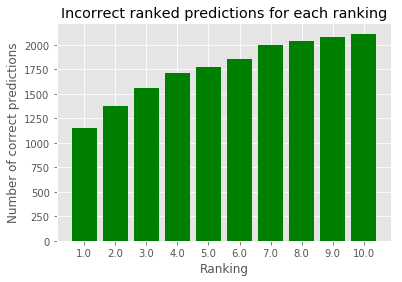

INFO:tensorflow:Restoring parameters from models/model_1.cptk


KeyboardInterrupt: 

In [7]:
# Initiate model and placeholders

max_accuracy = 0
best_model = -1

for e in range(train_config.epochs):
    tf.reset_default_graph()
    test_config.save_name = 'model_' + str(e) + '.cptk'

    model = SDCAE.SDCAE(mnist.train, mnist.validation, mnist.test)

    inputs_left = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs_left')
    targets_left = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets_left')

    inputs_right = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs_right')
    targets_right = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets_right')

    left = model.model(inputs_left,train_config,False)
    right = model.model(inputs_right,train_config,True)
    loss = model.loss(targets_left,left,targets_right,right,0)

    # Restore model
    sess = tf.Session()
    saver = tf.train.Saver()
    saver = saver.restore(sess, os.path.join(test_config.save_path,test_config.save_name))

    # Get test data
    imgs_left = np.reshape(model.validation.images[:test_config.num_test_imgs],(-1,28,28,1))
    imgs_right = np.reshape(model.validation.images[:test_config.num_test_imgs],(-1,28,28,1))

    # Get embeddings
    get_right_embeddings = model.get_right_embedding(right)
    get_left_embeddings = model.get_left_embedding(left)

    embeddings_left = sess.run([get_left_embeddings], feed_dict={inputs_left: imgs_left,
                                             targets_left: imgs_left,
                                             inputs_right: imgs_left,
                                             targets_right: imgs_left})


    embeddings_right = sess.run([get_right_embeddings], feed_dict={inputs_left: imgs_right,
                                             targets_left: imgs_right,
                                             inputs_right: imgs_right,
                                             targets_right: imgs_right})

    # Embeddings returned from test data
    embeddings_left = np.reshape(embeddings_left,(test_config.num_test_imgs,4,4,8))
    embeddings_right = np.reshape(embeddings_right,(test_config.num_test_imgs,4,4,8))
    
    
    predicted_labels = []
    num_samples = 10000
    neighbours = 10

    classifier = model.fit_KNN(embeddings_left, neighbours, p=2)
    print('Classifier fit. Finding nearest neighbours.')

    for query in range(num_samples):
        indices = model.K_nearest_neighbours(classifier, embeddings_left[query])
        predicted_labels = np.append(predicted_labels,indices)

    predicted_labels = np.reshape(predicted_labels,(num_samples, neighbours))

    accuracy, positions = model.model_accuracy(predicted_labels, num_samples, neighbours)
    
    if accuracy > max_accuracy:
        best_model = e+1
        max_accuracy = accuracy
    model.plot_bar_chart(positions, num_samples)
        

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(model.flatten_embeddings(embeddings_right))

plt.plot(tsne_results[:,0],tsne_results[:,1],'.')